In [30]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import PIL
import glob
from datetime import datetime

In [7]:
cand = pd.read_csv('data/candidatos.csv')
votos = pd.read_csv('data/votos.csv')

In [8]:
hist = cand[['ano', 'candidato_id', 'partido']]

In [11]:
hist.duplicated().any()

False

In [9]:
votos['date'] = votos['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
votos['ano'] = votos['date'].apply(lambda x:x.year)

In [10]:
df = pd.merge(hist, votos, on=['candidato_id', 'ano'], how='inner')

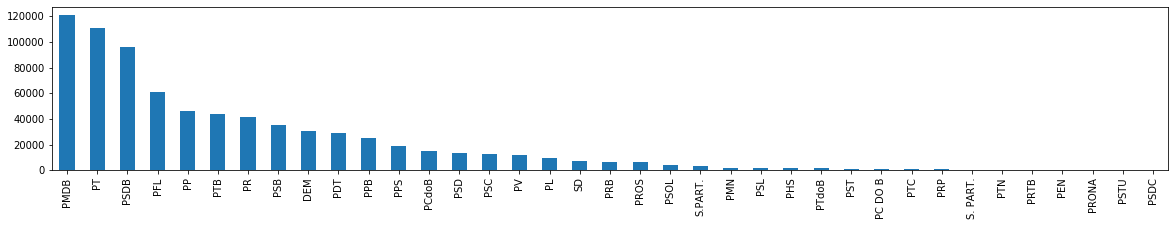

In [19]:
plt.figure(figsize=(20,3))
df['partido'].value_counts().plot(kind="bar")

In [33]:
df['ano'].value_counts().sort_index()

1996    29269
1997    25699
1998     6566
1999      567
2000    75260
2001    43689
2002    18819
2004    53782
2005    42288
2006    48537
2008    69089
2009    66876
2010    38749
2012    29242
2013    58869
2014    31888
Name: ano, dtype: int64

In [20]:
partido_cont = df['partido'].value_counts()
mfp = partido_cont[partido_cont > 20000].index.values.tolist()
df = df[df['partido'].isin(mfp)]

In [21]:
v = pd.pivot_table(df, values='voto', index=['candidato_id', 'partido'], columns='sessao_id', fill_value=0)

In [22]:
v

sessao_id             01/1991  011/2001  052/1999  071/98  08/99  09/99  \
candidato_id partido                                                      
3151         DEM            0         0         0       0   0.00    0.0   
3155         DEM            0         0         0       0   0.00    0.0   
4927         DEM            0         0         0       0   0.00    0.0   
4929         PSB            0         0         0       0   0.00    0.0   
             PT             0         0         0       0   0.00    0.0   
4930         PTB            0         0         0       0   0.00    0.0   
4931         PSDB           0         0         0       0   0.00    0.0   
62881        PMDB           0         0         0       0   0.00    0.0   
62926        PTB            0         0         0       0   0.00    0.0   
64224        PFL            0         0         0       0   0.00    0.0   
64960        PSB            0         0         0       0   0.00    0.0   
65498        PSDB           1        -1         0       0   0.50    0.0   
65511        PSB            0         0         0       0   0.00    0.0   
65551        PDT            0         0         0       0   0.00    0.0   
65904        PMDB           0        -1         0       0   0.75    0.0   
65987        PMDB           0         0         0       0   0.00    0.0   
66476        PDT            0         0         0       0   0.00    0.0   
66490        PSDB           0         0         0       0   0.00    0.0   
67105        PT             0         0         0       0   0.00    0.0   
67138        PP             0         0         0       0   0.00    0.0   
67836        PT             0         0         0       0   0.00    0.0   
68676        PT             0         0         0       0   0.00    0.0   
72553        PMDB           0         0         0       0   0.00    0.0   
73416        PMDB           0         0         0       0   0.00    0.0   
             PSDB           0         0         0       0   0.00    0.0   
73417        PSDB           0         0         0       0   0.00    0.0   
73418        PMDB           0         0         0       0   0.00    0.0   
73419        PPB            0         0         0       0   0.00    0.0   
73420        PTB            1         0         0       0   0.75    0.0   
73421        PSDB           0         0         0       0   0.75    0.0   
...                       ...       ...       ...     ...    ...    ...   
166401       PSDB           0         0         0       0   0.00    0.0   
166402       PR             0         0         0       0   0.00    0.0   
167493       PDT            0         0         0       0   0.00    0.0   
167614       PSB            0         0         0       0   0.00    0.0   
167617       PT             0         0         0       0   0.00    0.0   
167707       PMDB           0         0         0       0   0.00    0.0   
167722       PDT            0         0         0       0   0.00    0.0   
168034       PSB            0         0         0       0   0.00    0.0   
168447       PMDB           0         0         0       0   0.00    0.0   
169553       PMDB           0         0         0       0   0.00    0.0   
169711       PSDB           0         0         0       0   0.00    0.0   
169712       PSB            0         0         0       0   0.00    0.0   
170489       PDT            0         0         0       0   0.00    0.0   
171617       PT             0         0         0       0   0.00    0.0   
171618       DEM            0         0         0       0   0.00    0.0   
171619       PT             0         0         0       0   0.00    0.0   
171620       PP             0         0         0       0   0.00    0.0   
171622       PR             0         0         0       0   0.00    0.0   
171623       PMDB           0         0         0       0   0.00    0.0   
172029       PT             0         0         0       0   0.00    0.0   
172711       PSDB        

In [23]:
part = v.reset_index().drop('candidato_id', axis=1).groupby('partido').mean()

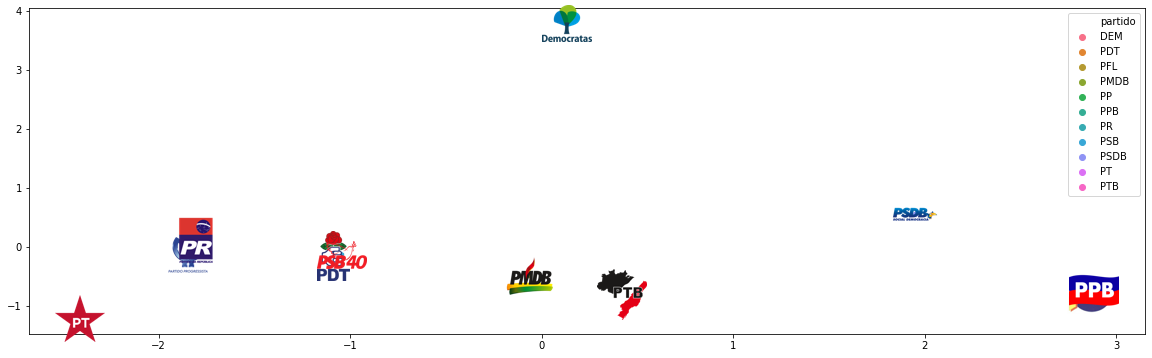

In [31]:
x, y = PCA(2).fit_transform(part).T
fig, ax = plt.subplots(figsize=(20, 6))

def getImage(partido):
    p = partido.upper().replace(' ', '')
    path = glob.glob(f"../logos/{p}.*")[0]
    img = PIL.Image.open(path)
    img.thumbnail((50, 50))
    return OffsetImage(img)

sns.scatterplot(x, y, hue=part.index)
for x0, y0, path in zip(x, y, part.index.tolist()):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [81]:
x, y = PCA(2).fit_transform(v).T

plt.figure(figsize=(20,10))
partido = v.index.get_level_values('partido')
sns.scatterplot(x, y, hue=partido)